# W&B Checkpoint Loader and Hessian Tools
Utility notebook to restore a training run at a chosen step, reload the dataset, compute Hessian eigenvalues, and run additional optimizer steps.


**Usage**
- Set `RUN_ID` (or `RUN_PATH`) and `TARGET_STEP` below.
- Ensure `DATASETS` & `WANDB_DIR` environment variables point to your dataset root and W&B workspace.
- Execute cells sequentially to inspect eigenvalues or continue optimization from the restored checkpoint.


In [2]:
import os, sys
import json
from pathlib import Path
from typing import Optional, Dict, Any, Tuple

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.nn.utils import parameters_to_vector, vector_to_parameters


sys.path.append('..')

from utils.data import prepare_dataset
from utils.nets import prepare_net_dataset_specific, initialize_net, prepare_optimizer, SquaredLoss
from utils.wandb_utils import find_closest_checkpoint_wandb, load_checkpoint_wandb, get_checkpoint_dir_for_run
from utils.measure import compute_eigenvalues
import sys



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

torch.set_num_threads(40)


Using device: cpu


In [3]:
# --- User configuration (edit as needed) ---

WANDB_BASE_DIR = Path(os.environ.get('WANDB_DIR', '.'))
# DATASETS_ROOT = Path(os.environ.get('DATASETS', '/scratch/gpfs/andreyev/datasets'))
DATASETS_ROOT = Path('/scratch/gpfs/andreyev/datasets')

RUN_ID = 'zc9aoqya'  # e.g. 'abcd1234'
RUN_PATH = None  # Optionally provide Path('/absolute/path/to/wandb/run-XYZ-abcd1234')
TARGET_STEP = 10000  # desired training step to restore (closest checkpoint ≤ this is used)

CHECKPOINT_DIR = None  # Optionally override checkpoint directory Path('.../wandb_checkpoints/abcd1234')
BATCH_SIZE_OVERRIDE = None  # Set to int to override logged batch size
LEARNING_RATE_OVERRIDE = None  # Set to float to override logged learning rate

NUM_EIGENVALUES = 1  # top-k Hessian eigenvalues to compute
USE_HVP_FOR_EIGS = True  # True -> use HVP-based routine, False -> autograd LOBPCG

print('WANDB_BASE_DIR:', WANDB_BASE_DIR)
print('DATASETS_ROOT:', DATASETS_ROOT)


WANDB_BASE_DIR: /scratch/gpfs/andreyev/eoss/results
DATASETS_ROOT: /scratch/gpfs/andreyev/datasets


In [4]:
import itertools


def extract_run_id(run_dir: Path) -> Optional[str]:
    meta_path = run_dir / "files" / "wandb-metadata.json"
    if meta_path.exists():
        try:
            meta = json.loads(meta_path.read_text())
            rid = meta.get("id")
            if rid:
                return rid
        except json.JSONDecodeError:
            pass
    return None


def locate_run_directory(run_id: Optional[str] = None,
                         run_path: Optional[Path] = None,
                         base_dir: Path = WANDB_BASE_DIR) -> Tuple[Path, str]:
    if run_path is not None:
        run_dir = Path(run_path).expanduser().resolve()
        if not run_dir.exists():
            raise FileNotFoundError(f"Provided RUN_PATH does not exist: {run_dir}")
        resolved_id = run_id or extract_run_id(run_dir)
        if resolved_id is None:
            raise ValueError("Could not infer run id from RUN_PATH; please set RUN_ID explicitly.")
        return run_dir, resolved_id

    if run_id is None:
        raise ValueError("Set RUN_ID or RUN_PATH to locate the Weights & Biases run.")

    run_id = run_id.strip()
    if not base_dir.exists():
        raise FileNotFoundError(f"WANDB_BASE_DIR does not exist: {base_dir}")

    base_dir = base_dir / 'wandb'
    candidates = sorted(base_dir.glob("offline-run-*"))
    # checkpoint_base_dir = wandb_dir / "wandb_checkpoints"

    for candidate in candidates:
        candidate_id = extract_run_id(candidate)
        if candidate_id == run_id:
            return candidate, run_id
        if candidate.name.endswith(run_id):
            return candidate, run_id

    raise FileNotFoundError(f"Could not find run directory for id='{run_id}' under {base_dir}.")


def _coerce_config_value(value: Any) -> Any:
    if isinstance(value, dict) and "value" in value:
        value = value["value"]

    if isinstance(value, str):
        text = value.strip().strip('"').strip("'")
        lowered = text.lower()
        if lowered in {"none", "null"}:
            return None
        if lowered == "true":
            return True
        if lowered == "false":
            return False
        try:
            return json.loads(text)
        except json.JSONDecodeError:
            return text
    return value


def load_wandb_config(run_dir: Path) -> Dict[str, Any]:
    files_dir = run_dir / "files"
    json_path = files_dir / "config.json"
    if json_path.exists():
        raw = json.loads(json_path.read_text())
        return {k: _coerce_config_value(v) for k, v in raw.items() if not k.startswith("_")}

    yaml_path = files_dir / "config.yaml"
    if yaml_path.exists():
        text = yaml_path.read_text()
        try:
            import yaml  # type: ignore
            raw = yaml.safe_load(text)
            return {
                k: _coerce_config_value(v.get("value") if isinstance(v, dict) else v)
                for k, v in raw.items()
                if not k.startswith("_")
            }
        except ImportError:
            config: Dict[str, Any] = {}
            current_key: Optional[str] = None
            for line in text.splitlines():
                if not line.strip():
                    continue
                if not line.startswith("  "):
                    current_key = line.split(":", 1)[0].strip()
                elif "value:" in line and current_key:
                    value_text = line.split("value:", 1)[1].strip()
                    config[current_key] = _coerce_config_value(value_text)
            return config

    raise FileNotFoundError(f"No config file found in {files_dir}")


def ensure_list(value: Any):
    if value is None:
        return value
    if isinstance(value, (list, tuple)):
        return list(value)
    if isinstance(value, str):
        try:
            parsed = json.loads(value)
            if isinstance(parsed, list):
                return parsed
        except json.JSONDecodeError:
            pass
        parts = [p.strip() for p in value.split(',') if p.strip()]
        if parts:
            result = []
            for p in parts:
                if p.isdigit():
                    result.append(int(p))
                else:
                    result.append(p)
            return result
        return []
    return [value]


def build_loss_fn(name: str) -> nn.Module:
    if not name:
        name = "mse"
    name = name.lower()
    if name in {"mse", "l2", "squared"}:
        return SquaredLoss()
    if name in {"ce", "cross_entropy", "crossentropy"}:
        return nn.CrossEntropyLoss()
    raise ValueError(f"Unsupported loss '{name}'")


def make_data_cycle(X: torch.Tensor, Y: torch.Tensor, batch_size: int, shuffle: bool = True):
    dataset = TensorDataset(X, Y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)
    def iterator():
        while True:
            for batch in loader:
                yield batch
    return loader, iterator()


def compute_top_hessian_for_batch(model: nn.Module,
                                  inputs: torch.Tensor,
                                  targets: torch.Tensor,
                                  loss_fn: nn.Module,
                                  k: int = 1,
                                  use_hvp: bool = True,
                                  eigenvector_cache=None,
                                  **kwargs):
    model.eval()
    inputs = inputs.to(device)
    targets = targets.to(device)
    if use_hvp:
        eigenvalues, eigenvectors = compute_eigenvalues_hvp(
            model,
            inputs,
            targets,
            loss_fn,
            k=k,
            eigenvector_cache=eigenvector_cache,
            return_eigenvectors=True,
            **kwargs,
        )
    else:
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        eigen_result = compute_eigenvalues(
            loss,
            model,
            k=k,
            eigenvector_cache=eigenvector_cache,
            return_eigenvectors=True,
            **kwargs,
        )
        if k == 1:
            eigen_value, eigen_vector = eigen_result
            eigenvalues = torch.as_tensor([float(eigen_value)])
            eigenvectors = eigen_vector.unsqueeze(1)
        else:
            eigenvalues, eigenvectors = eigen_result
    return eigenvalues.detach().cpu(), eigenvectors


def run_optimizer_steps(model: nn.Module,
                        optimizer: torch.optim.Optimizer,
                        data_iter,
                        loss_fn: nn.Module,
                        num_steps: int,
                        log_every: int = 1):
    model.train()
    history = []
    for step in range(1, num_steps + 1):
        inputs, targets = next(data_iter)
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_value = float(loss.detach().cpu())
        history.append(loss_value)
        if log_every and step % log_every == 0:
            print(f"Step {step:04d} | loss: {loss_value:.6f}")
    return history


In [5]:
run_dir, resolved_run_id = locate_run_directory(run_id=RUN_ID or None, run_path=RUN_PATH)
print(f'Using run directory: {run_dir}')
config = load_wandb_config(run_dir)
print(f'Loaded {len(config)} config entries. Keys: {sorted(config.keys())}')


Using run directory: /scratch/gpfs/andreyev/eoss/results/wandb/offline-run-20250822_090227-zc9aoqya
Loaded 50 config entries. Keys: ['adam', 'batch', 'batch_lambdamax', 'batch_sharpness', 'batch_sharpness_mc', 'batch_sharpness_static', 'batch_sharpness_step', 'checkpoint_every', 'classes', 'cont_epoch', 'cont_folder', 'cont_last', 'cont_run_id', 'cont_step', 'dataset', 'dataset_seed', 'disable_cache_eigenvectors', 'epochs', 'final', 'fisher', 'gd_noise', 'gni', 'gradient_norm', 'init_scale', 'init_seed', 'init_sharp', 'lambdamax', 'loss', 'lr', 'model', 'momentum', 'no_init', 'noise_mag', 'num_data', 'num_eigenvalues', 'param_distance', 'param_file', 'quad_switch_step', 'results_rarely', 'sde', 'sde_eta', 'sde_h', 'sde_seed', 'sharp_every', 'steps', 'stop_loss', 'use_gauss_newton', 'use_power_iteration', 'wandb_tag', 'wandb_version']


In [6]:
dataset_name = config.get('dataset', 'cifar10')
num_data = int(config.get('num_data', 1024))
classes = ensure_list(config.get('classes', [1, 9])) or [1, 9]
dataset_seed = int(config.get('dataset_seed', 888))
loss_name = config.get('loss', 'mse')

if not DATASETS_ROOT.exists():
    raise FileNotFoundError(f'DATASETS_ROOT not found: {DATASETS_ROOT}')

X_train, Y_train, X_test, Y_test = prepare_dataset(
    dataset_name,
    DATASETS_ROOT,
    num_data,
    classes,
    dataset_seed=dataset_seed,
    loss_type=loss_name,
)
print(f'Training tensors: {tuple(X_train.shape)} | Targets: {tuple(Y_train.shape)}')
print(f'Test tensors: {tuple(X_test.shape)} | Targets: {tuple(Y_test.shape)}')


Training tensors: (8192, 3, 32, 32) | Targets: (8192, 10)
Test tensors: (10000, 3, 32, 32) | Targets: (10000, 10)


In [7]:
model_name = config.get('model', 'mlp')
net = prepare_net_dataset_specific(model_name, dataset_name)
net.to(device)

if not config.get('no_init', False):
    initialize_net(net, scale=config.get('init_scale'), seed=config.get('init_seed'))

learning_rate = float(LEARNING_RATE_OVERRIDE if LEARNING_RATE_OVERRIDE is not None else config.get('lr', 0.001))
batch_size = int(BATCH_SIZE_OVERRIDE if BATCH_SIZE_OVERRIDE is not None else config.get('batch', 64))
momentum = config.get('momentum', None)
if isinstance(momentum, str) and momentum.lower() in {'none', 'null'}:
    momentum = None
momentum = None if momentum is None else float(momentum)
adam_flag = bool(config.get('adam', False))

optimizer = prepare_optimizer(net, lr=learning_rate, momentum=momentum, adam=adam_flag)
loss_fn = build_loss_fn(loss_name)

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Model: {model_name} | parameters: {param_count:,}')
print(f"Optimizer: {'Adam' if adam_flag else 'SGD'} | lr={learning_rate} | batch size={batch_size}")


Model: mlp | parameters: 1,841,162
Optimizer: SGD | lr=0.005 | batch size=16


In [8]:
checkpoint_directory = Path(CHECKPOINT_DIR).expanduser().resolve() if CHECKPOINT_DIR else get_checkpoint_dir_for_run(resolved_run_id)
if checkpoint_directory is None or not checkpoint_directory.exists():
    raise FileNotFoundError(f"No checkpoint directory found for run '{resolved_run_id}'.")

checkpoint_info = find_closest_checkpoint_wandb(TARGET_STEP, run_id=resolved_run_id, checkpoint_dir=checkpoint_directory)
if checkpoint_info is None:
    raise FileNotFoundError(f'No checkpoint available at or before step {TARGET_STEP}.')

checkpoint_data = load_checkpoint_wandb(checkpoint_info, net, optimizer)
restored_step = checkpoint_data['step']
restored_epoch = checkpoint_data['epoch']
restored_loss = checkpoint_data['loss']
print(f"Restored step={restored_step}, epoch={restored_epoch}, recorded loss={restored_loss}")


Restored step=9744, epoch=19, recorded loss=0.31078240275382996


In [9]:
train_loader, train_cycle = make_data_cycle(X_train, Y_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)
print(f'Train loader: {len(train_loader.dataset)} samples | {len(train_loader)} batches/epoch')
print(f'Test loader: {len(test_loader.dataset)} samples | {len(test_loader)} batches/epoch')


Train loader: 8192 samples | 512 batches/epoch
Test loader: 10000 samples | 625 batches/epoch


In [10]:
X_train.shape

torch.Size([8192, 3, 32, 32])

## Some small checks

In [11]:
X = X_train.to(device)
Y = Y_train.to(device)

In [12]:
preds = net(X).squeeze()
loss = loss_fn(preds, Y)
loss.mean()


tensor(0.3756, grad_fn=<MeanBackward0>)

In [13]:
loss.shape

torch.Size([])

## View landscape

In [16]:
optimizer.param_groups[0]['lr']

0.005

0.4130029082298279
Alpha 00 | Loss: 0.373849
Alpha 01 | Loss: 0.372309
Alpha 02 | Loss: 0.371269
Alpha 03 | Loss: 0.370724
Alpha 04 | Loss: 0.370672
Alpha 05 | Loss: 0.371102
Alpha 06 | Loss: 0.372011
Alpha 07 | Loss: 0.373396
Alpha 08 | Loss: 0.375244
Alpha 09 | Loss: 0.377542


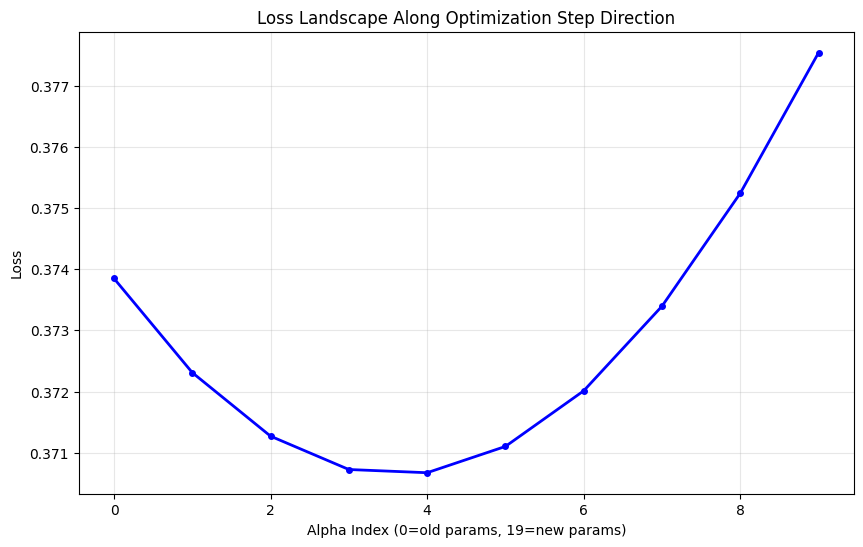

In [20]:
old_params = parameters_to_vector(net.parameters()).clone().detach()
batch_idx = torch.randperm(X.shape[0])[:batch_size]

X_batch = X[batch_idx]
Y_batch = Y[batch_idx]

optimizer.zero_grad(set_to_none=True)
outputs = net(X_batch).squeeze()
loss = loss_fn(outputs, Y_batch)
loss.backward()
print(loss.item())
optimizer.step()

new_params = parameters_to_vector(net.parameters()).clone().detach()

delta_params = new_params - old_params
intermediate_params = [old_params + alpha * delta_params for alpha in torch.linspace(0, 1, steps=10)]
losses = []
for i, params in enumerate(intermediate_params):
    vector_to_parameters(params, net.parameters())
    preds = net(X).squeeze()
    loss = loss_fn(preds, Y)
    losses.append(loss.mean().item())
    print(f'Alpha {i:02d} | Loss: {loss.mean().item():.6f}')



import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Alpha Index (0=old params, 19=new params)')
plt.ylabel('Loss')
plt.title('Loss Landscape Along Optimization Step Direction')
plt.grid(True, alpha=0.3)
plt.show()